<img src="https://www.alura.com.br/artigos/assets/para-que-serve-adobe-illustrator/imagem1.jpg" alt="Imagem1.png" width="300" />


# **Redes Neurais Transformers: Deep Learning com Pytorch**
---



### **0. Introdução Teórica — O que é um Transformer?**

Tarefas de linguagem e sequência eram dominadas por RNNs/LSTMs, que processam token a token e sofrem com paralelização limitada e dependências longas. O paper [*Attention is All You Need*](https://arxiv.org/pdf/1706.03762) mostrou que é possível **modelar relações entre quaisquer posições da sequência em paralelo**, via **atenção** tornando o treino muito mais eficiente e escalável.


#### Arquitetura da Rede Neural

<img src="https://img-blog.csdnimg.cn/direct/90ad2fa8c00f4bc78c8a035ddc45f28b.png" alt="Imagem1.png" width="500" />


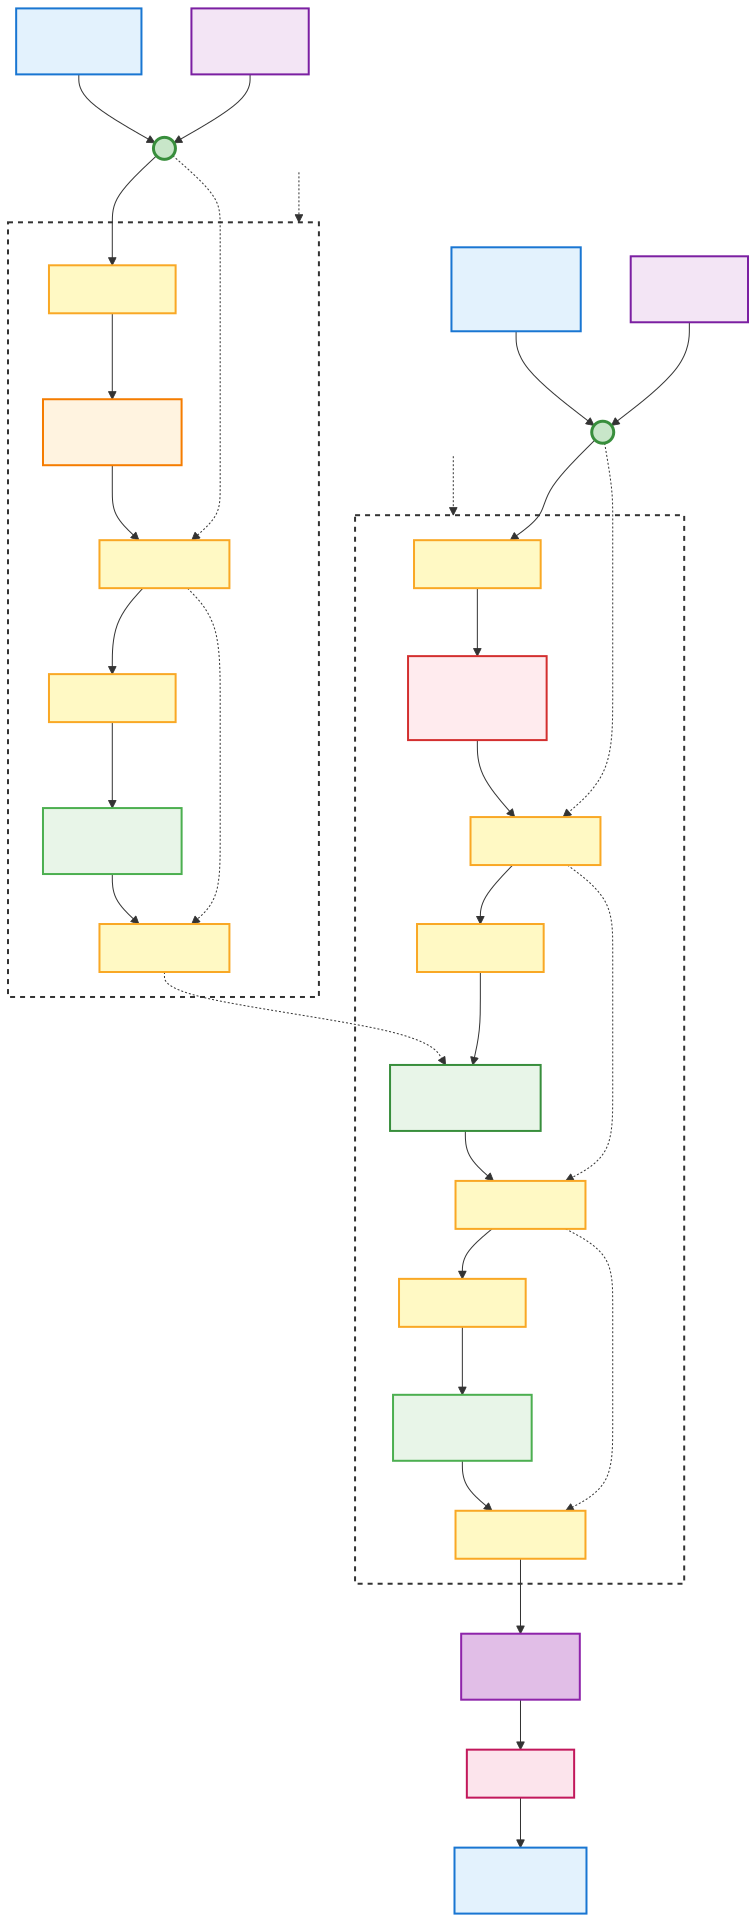

In [ ]:
display(SVG(resp.text))

#### Ideia central: Atenção (Self-Attention)

Cada token “pergunta” ao restante da sequência o que é relevante para compor sua nova representação.

- Três projeções lineares: **Q** (queries), **K** (keys), **V** (values)  
- Similaridade: $ \text{scores} = \dfrac{QK^\top}{\sqrt{d_k}} $  
- Pesos: $ \text{softmax}(\text{scores}) $  
- Saída: média ponderada de $V$

$$
\text{Attention}(Q,K,V)\;=\;\text{softmax}\!\left(\frac{QK^\top}{\sqrt{d_k}}\right)\,V
$$

**Intuição:** $Q$ = “o que eu procuro”; $K$ = “o que eu ofereço”; $V$ = “o que eu trago de informação”.


#### Multi-Head Attention



Em vez de uma única atenção, usamos **várias cabeças** (heads). Cada cabeça aprende “padrões” distintos (curta/longa distância, sintaxe, estilo…). As saídas são concatenadas e projetadas de volta para $d_{\text{model}}$:

$$
\text{MHA}(Q,K,V)\;=\;\text{Concat}(\text{head}_1,\dots,\text{head}_h)\,W^{O}
$$


#### Posições importam: Positional Encoding


Como o Transformer não é recorrente, adicionamos uma “assinatura rítmica” para a **ordem** dos tokens.

- **Senoidal clássica** (não-treinável), usada nesta aula:
$$
\mathrm{PE}(pos,2i) = \sin\!\left(\frac{pos}{10000^{\frac{2i}{d}}}\right),\qquad
\mathrm{PE}(pos,2i+1) = \cos\!\left(\frac{pos}{10000^{\frac{2i}{d}}}\right)
$$

- Alternativa: **embeddings de posição aprendíveis**.


### **1. Configuração do Ambiente**

In [ ]:
!pip install transformers sentencepiece -q

In [ ]:
!pip install datasets -q

In [ ]:
# Importações essenciais
import re
import shutil
import unicodedata
import torch
import math
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from typing import Dict, List, Optional, Tuple, Union
from dataclasses import dataclass
from collections import Counter
import polars as pl
from tqdm import tqdm
import json
import random
import warnings
from datasets import load_dataset

# Importar tokenizer pré-treinado
from transformers import AutoTokenizer
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.amp import autocast, GradScaler

# Verificar se temos GPU disponível
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Usando: cuda
GPU: NVIDIA A100-SXM4-40GB


In [ ]:
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

### **2. Download e Preparação do Dataset**

Carregamos a base de dados brasileira do Kaggle, [pablo-moreira/wikipedia-pt](https://huggingface.co/datasets/pablo-moreira/wikipedia-pt), por meio da classe `WikipediaPortuguesLoader`.

In [ ]:
from huggingface_hub import login
login(token='hf_...')

In [ ]:
class WikipediaPortuguesLoader:

    def __init__(self, dataset_path: str = 'hf://datasets/pablo-moreira/wikipedia-pt/latest/train-*.parquet'):
        print("Carregando dataset...")
        self.df = pl.read_parquet(dataset_path, columns=['text'])
        print(f"Carregado: {len(self.df):,} artigos")

    def carregar_tudo(self, limite_caracteres: int = 500_000, sep_token: str = "[SEP]",
                      inserir_sep_final: bool = True) -> str:

        print("Processando textos...")

        # Limpa e filtra textos de forma rigorosa (conforme seu pipeline atual)
        df_limpo = (
            self.df
            .filter(pl.col("text").str.len_chars() > 100)  # pegar texto com mais de 100 caracteres
            .with_columns([
                pl.col("text")
                # Remover elementos específicos da Wikipedia
                .str.replace_all(r'\[\d+\]', ' ')  # Referências [1], [2]
                .str.replace_all(r'\{\{[^}]*\}\}', ' ')  # Templates {{...}}
                .str.replace_all(r'\[\[([^\]|]+)(?:\|([^\]]+))?\]\]', r'$2')  # Links [[...]]
                .str.replace_all(r'\[\[([^\]]+)\]\]', r'$1')  # Links simples

                # URLs, emails, HTML
                .str.replace_all(r'https?://\S+|www\.\S+|\S+@\S+|@\w+', ' ')
                .str.replace_all(r'<[^>]+>', ' ')  # Tags HTML
                .str.replace_all(r'&\w+;', ' ')   # Entidades HTML (&amp;, &nbsp;)
                .str.replace_all(r'==+[^=]*==+', ' ')  # Headers wiki (==Título==)

                # Caracteres de controle e problemáticos
                .str.replace_all(r'[\x00-\x08\x0B\x0C\x0E-\x1F\x7F]', ' ')

                # Normalizar pontuação
                .str.replace_all(r'[""„‚]', '"')  # Aspas diferentes
                .str.replace_all(r'[''‛]', "'")   # Aspas simples
                .str.replace_all(r'[–—]', '-')    # Travessões
                .str.replace_all(r'[…]', '...')   # Reticências

                # Remover números longos sem contexto e símbolos matemáticos
                .str.replace_all(r'\b\d{5,}\b', ' ')  # Números muito longos
                .str.replace_all(r'[≈≠≤≥±∞∫∑∏√∂∇∆Ω∀∃∈∉⊂⊃⊆⊇°§]', ' ')

                # Manter apenas caracteres válidos para português
                .str.replace_all(r"[^a-zA-ZáéíóúâêôãõçàÁÉÍÓÚÂÊÔÃÕÇÀüÜ0-9\s\.\,\;\:\!\?\-\(\)\"\'%]", ' ')

                # Limpar múltipla pontuação
                .str.replace_all(r'\.{2,}', '.')
                .str.replace_all(r',{2,}', ',')
                .str.replace_all(r';{2,}', ';')
                .str.replace_all(r':{2,}', ':')
                .str.replace_all(r'\!{2,}', '!')
                .str.replace_all(r'\?{2,}', '?')

                # Espaços e formatação final
                .str.replace_all(r'\s+([,.:;!?])', r'$1')  # Remove espaço antes de pontuação
                .str.replace_all(r'\s+', ' ')              # Múltiplos espaços
                .str.strip_chars()
            ])
            .filter(
                (pl.col("text").str.len_chars() > 50) &
                (pl.col("text").str.len_chars() < 5000) &  # Não muito longo
                # Pelo menos 70% de caracteres alfabéticos
                (pl.col("text").str.count_matches(r'[a-zA-ZáéíóúâêôãõçàÁÉÍÓÚÂÊÔÃÕÇÀüÜ]') * 100 / pl.col("text").str.len_chars() > 70) &
                # Deve ter pelo menos uma frase completa
                pl.col("text").str.contains(r'[.!?]\s*[A-ZÁÉÍÓÚÂÊÔÃÕÇÀÜÜ]')
            )
        )

        print(f"Após limpeza: {len(df_limpo):,} artigos")

        # Converter para lista mantendo ordem original
        textos = df_limpo.get_column("text").to_list()

        # --- Concatenação com DELIMITADOR [SEP] ---
        # Estratégia:
        #   Para cada artigo, adicionamos: "[SEP]\n" + texto.strip() + "\n"
        #   Isso cria fronteiras claras entre documentos.
        #   Respeitamos 'limite_caracteres' e cortamos o último texto em fronteira de frase, se necessário.
        corpus_parts = []
        total_len = 0
        textos_adicionados = 0

        # Pré-calculamos o custo fixo do prefixo/sufixo de cada bloco
        prefix = f"{sep_token}\n"
        suffix = "\n"
        prefix_len = len(prefix)
        suffix_len = len(suffix)

        for texto in textos:
            t = (texto or "").strip()
            if not t:
                continue

            bloco = f"{prefix}{t}{suffix}"
            bloco_len = len(bloco)

            # Cabe inteiro?
            if total_len + bloco_len <= limite_caracteres:
                corpus_parts.append(bloco)
                total_len += bloco_len
                textos_adicionados += 1
                continue

            # Se não cabe inteiro, tentamos um corte "limpo" (até fim de frase) se houver espaço suficiente
            restante = limite_caracteres - total_len
            # Espaço disponível para o conteúdo (descontando prefixo/sufixo)
            disponivel_para_texto = restante - prefix_len - suffix_len

            if disponivel_para_texto > 100:
                # Cortamos o texto no que cabe e tentamos encontrar a última sentença completa
                parc = t[:max(0, disponivel_para_texto)]
                # Procura o último delimitador de frase que caiba
                ponto = max(parc.rfind('.'), parc.rfind('!'), parc.rfind('?'))
                if ponto > 0:
                    bloco = f"{prefix}{parc[:ponto+1].rstrip()}{suffix}"
                    corpus_parts.append(bloco)
                    total_len += len(bloco)
                    textos_adicionados += 1
            # Independente do corte, atingimos o limite
            break

        corpus = "".join(corpus_parts).strip()

        # [SEP] final para marcar término do último documento
        if inserir_sep_final:
            final_tag = f"{sep_token}\n"
            if not corpus.endswith(final_tag):
                # Se ainda houver espaço para adicionar o [SEP] final sem estourar o limite
                if len(corpus) + len(final_tag) <= limite_caracteres:
                    corpus += ("\n" if not corpus.endswith("\n") else "") + final_tag
                # Senão, ignora silenciosamente (prioriza conteúdo)

        print(f"Concluído: {len(corpus):,} caracteres de {textos_adicionados:,} textos (limite: {limite_caracteres:,})")
        return corpus


In [ ]:
# Carrega o dataset
loader = WikipediaPortuguesLoader()
textos = loader.carregar_tudo(limite_caracteres = 500_000_000)
print("Exemplo de Texto:\n", textos[1200:2300])

Carregando dataset...
Carregado: 1,857,355 artigos
Processando textos...
Após limpeza: 833,348 artigos
Concluído: 499,999,921 caracteres de 462,345 textos (limite: 500,000,000)
Exemplo de Texto:
 ra do Tejo. Segundo Bernardo Rodrigues, em os "Anais de Arzila", o seu aio era João de Meneses, conde de Cantanhede, e esse acontecimento terá ocasionado nesta personagem um grande traumatismo: Depois da morte de D. Afonso, nomeou como sucessor o Duque de Beja, seu primo, que viria a governar como e que casou depois com Isabel, a viúva do infante Afonso.
[SEP]
A Ideia Perigosa de Darwin A Ideia Perigosa de Darwin (em Portugal) ou A Perigosa Ideia de Darwin (no Brasil), Darwin's Dangerous Idea no original em inglês, é um livro da autoria de Daniel C. Dennett (1995) que explora os efeitos que a teoria da evolução de Charles Darwin terá produzido no pensamento filosófico ocidental. Segundo o autor, a teoria de Darwin sugere que a vida no planeta Terra foi produzida por um processo algorítmico abs

### **3. Tokenizer Pre-Treinado**

Para a tokenização, utilizamos o modelo [neuralmind/bert-large-portuguese-cased](https://huggingface.co/neuralmind/bert-large-portuguese-cased) exclusivamente como tokenizer. O objetivo é explorar seu vocabulário robusto em português, adicionando marcações específicas para estruturar narrativas.

- Definimos o EOS (end-of-sequence) como o token `[SEP]`.

- Opcionalmente, o BOS (begin-of-sequence) pode ser definido como `[CLS]`.

In [ ]:
class BertTokenizerWrapper:
    def __init__(self):
        self.tokenizer = AutoTokenizer.from_pretrained(
            "neuralmind/bert-large-portuguese-cased"
        )
        # Evita pós-processamento que às vezes cola espaços/pontuação
        self.tokenizer.clean_up_tokenization_spaces = False

        # Garantir mapeamentos BOS/EOS usados em modelos auto-regressivo
        if self.tokenizer.sep_token_id is not None:
            self.tokenizer.eos_token = self.tokenizer.sep_token
            self.tokenizer.eos_token_id = self.tokenizer.sep_token_id

        if self.tokenizer.cls_token_id is not None:
            self.tokenizer.bos_token = self.tokenizer.cls_token
            self.tokenizer.bos_token_id = self.tokenizer.cls_token_id

        self.vocab_size = len(self.tokenizer)
        self.pad_id = self.tokenizer.pad_token_id
        self.eos_id = self.tokenizer.eos_token_id
        self.bos_id = self.tokenizer.bos_token_id

    def encode(self, text: str, max_length: int = None) -> List[int]:
        # Mantém add_special_tokens=False para LM (não injeta [CLS]/[SEP] extras)
        return self.tokenizer.encode(
            text,
            truncation=bool(max_length),
            max_length=max_length,
            add_special_tokens=False
        )

    def decode(self, ids: List[int]) -> str:
        # Remove tokens especiais ao exibir
        return self.tokenizer.decode(ids, skip_special_tokens=True)

    def batch_encode(self, texts: List[str], max_length: int = 512) -> Dict:
        return self.tokenizer(
            texts,
            truncation=True,
            padding=True,
            max_length=max_length,
            return_tensors="pt",
            add_special_tokens=False
        )

In [ ]:
# Criar tokenizer BERTimbau
tokenizer = BertTokenizerWrapper()
vocab_size = tokenizer.vocab_size

# Testar tokenizer
sample_text = "[SEP] O gato subiu no telhado ontem à noite sozinho porque estava assustado"
encoded = tokenizer.encode(sample_text)
decoded = tokenizer.decode(encoded)

print(f"Tamanho do Vocabulário: {vocab_size}")
print(f"Texto original: {sample_text}")
print(f"Tokens: (primeiros 10) {encoded}")
print(f"Decodificado: {decoded}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/155 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/648 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Tamanho do Vocabulário: 29794
Texto original: [SEP] O gato subiu no telhado ontem à noite sozinho porque estava assustado
Tokens: (primeiros 10) [102, 231, 15997, 10996, 202, 16267, 3185, 2097, 353, 2954, 10580, 2113, 1011, 17154, 487]
Decodificado: O gato subiu no telhado ontem à noite sozinho porque estava assustado


### **4. Positional Encoding**

Transformers não possuem, por natureza, um senso de ordem entre os tokens. Para resolver isso, adicionamos um **carimbo de posição** ao embedding de cada palavra. Utilizamos o positional encoding senoidal clássico, baseado em senos e cossenos com diferentes frequências:

$$PE(pos, 2i)   = \sin\!\left(\frac{pos}{10000^{\tfrac{2i}{d}}}\right)$$

$$PE(pos, 2i+1) = \cos\!\left(\frac{pos}{10000^{\tfrac{2i}{d}}}\right)$$

$\text{onde:}$  
$\quad pos$ posição do token na sequência  

$\quad i$ índice da dimensão do embedding

$\quad d$ dimensionalidade total do embedding

Esse mecanismo permite ao modelo compreender relações relativas, quem vem antes ou depois, e ainda generalizar para sequências mais longas do que as observadas durante o treino.

Como alternativa, pode-se usar uma camada aprendível `nn.Embedding(max_len, d_model)`, que aprende representações de posição em vez de defini-las de forma determinística.

In [ ]:
d_model = 8  # deve ser par
frase = "O gato brinca com o cachorro"
palavras = frase.split(" ")
seq_len = len(palavras)

In [ ]:
# Criar matriz de positional encoding
pe = np.zeros((seq_len, d_model))

In [ ]:
# Para cada posição na sequência
for pos in range(seq_len):
    # Para cada dimensão
    for i in range(0, d_model, 2):
        # Calcular divisor
        div_term = 10000 ** (i / d_model)

        # Aplicar seno e cosseno
        pe[pos, i] = math.sin(pos / div_term)      # dimensões pares
        pe[pos, i + 1] = math.cos(pos / div_term)  # dimensões ímpares

pe.round(3)

array([[ 0.   ,  1.   ,  0.   ,  1.   ,  0.   ,  1.   ,  0.   ,  1.   ],
       [ 0.841,  0.54 ,  0.1  ,  0.995,  0.01 ,  1.   ,  0.001,  1.   ],
       [ 0.909, -0.416,  0.199,  0.98 ,  0.02 ,  1.   ,  0.002,  1.   ],
       [ 0.141, -0.99 ,  0.296,  0.955,  0.03 ,  1.   ,  0.003,  1.   ],
       [-0.757, -0.654,  0.389,  0.921,  0.04 ,  0.999,  0.004,  1.   ],
       [-0.959,  0.284,  0.479,  0.878,  0.05 ,  0.999,  0.005,  1.   ]])

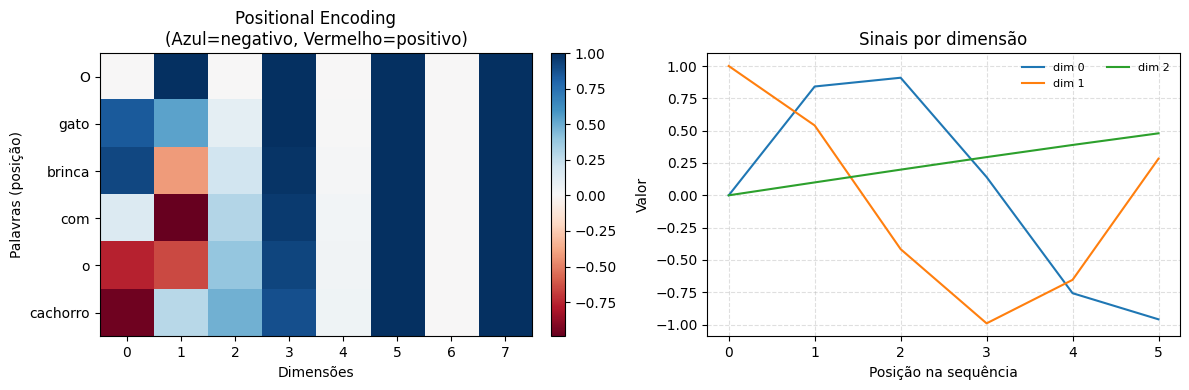

In [ ]:
# Visualização
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

im = ax[0].imshow(pe, cmap='RdBu', aspect='auto')
ax[0].set_title('Positional Encoding\n(Azul=negativo, Vermelho=positivo)')
ax[0].set_xlabel('Dimensões')
ax[0].set_ylabel('Palavras (posição)')
ax[0].set_xticks(np.arange(d_model))
ax[0].set_yticks(np.arange(seq_len))
ax[0].set_yticklabels(palavras)
fig.colorbar(im, ax=ax[0], fraction=0.046, pad=0.04)

# Curvas por dimensão ao longo das posições
for k in range(3): #Escolhendo 3 posições
    ax[1].plot(np.arange(seq_len), pe[:, k], label=f'dim {k}')
ax[1].set_title('Sinais por dimensão')
ax[1].set_xlabel('Posição na sequência')
ax[1].set_ylabel('Valor')
ax[1].grid(True, linestyle='--', alpha=0.4)
ax[1].legend(ncol=2, fontsize=8, frameon=False)

plt.tight_layout()
plt.show()

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int = 5000):
        super().__init__()

        # Codificação sinusoidal (como Transformer original)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()

        # Criar divisores para frequências diferentes
        div_term = torch.exp(torch.arange(0, d_model, 2).float() *
                           -(math.log(10000.0) / d_model))

        # Aplicar seno e cosseno
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        x: [batch_size, seq_len, d_model]
        """
        B, T, C = x.shape

        return x + self.pe[:, :T, :]

### **5. Scaled Dot‑Product Attention SDPA**

Aqui está o coração do Transformer: a atenção escalada por produto interno.  

$$
\text{Attention}(Q, K, V) = \text{softmax}\!\left(\frac{QK^T}{\sqrt{d_k}}\right)V
$$

$\text{onde:}$  
$\quad Q \;=\; \text{matriz de consultas (queries)},$  
$\quad K \;=\; \text{matriz de chaves (keys)},$  
$\quad V \;=\; \text{matriz de valores (values)},$  
$\quad d_k \;=\; \text{dimensão das chaves/consultas}.$  

Dividimos por $\sqrt{d_k}$ para estabilizar a escala e aplicamos a função $softmax$, que transforma os resultados em pesos de atenção. Esses pesos determinam quanto cada valor em $V$ deve contribuir para a representação final.  

Além disso, usamos uma **máscara causal** para impedir que o modelo, durante a geração, “espie” tokens futuros.  

> 💡 **Intuição:**  
> - $Q$ representa **o que cada palavra pergunta**,  
> - $K$ representa **o que cada palavra responde**,  
> - $V$ representa **o que cada palavra contribui**.  
>   
> O resultado é uma **média ponderada dos valores $V$**, guiada pelo quão bem as consultas $Q$ se alinham com as chaves $K$.

In [ ]:
palavras = ["Eu", "Jogo", "Tibia"]
seq_len = len(palavras)

In [ ]:
# o que cada palavra 'pergunta' (Query)
Q = np.array([
        [0.62, 0.27, 0.11],  # Eu pergunta sobre...
        [0.33, 0.41, 0.26],  # Jogo pergunta sobre...
        [0.18, 0.29, 0.53]   # Tibia pergunta sobre...
    ])

# o que cada palavra 'responde' (Key)
K = np.array([
        [0.65, 0.22, 0.13],  # Eu responde a...
        [0.28, 0.44, 0.28],  # Jogo responde a...
        [0.15, 0.25, 0.60]   # Tibia responde a...
    ])

# o que cada palavra 'contribui' (Value)
V = np.array([
        [0.58, 0.30, 0.12],  # Eu contribui com...
        [0.29, 0.37, 0.34],  # Jogo contribui com...
        [0.20, 0.31, 0.49]   # Tibia contribui com...
    ])


In [ ]:
# Calcular similaridades (Q * K^T)
scores = Q @ K.T
scores

array([[0.4767, 0.3232, 0.2265],
       [0.3385, 0.3456, 0.308 ],
       [0.2497, 0.3264, 0.4175]])

In [ ]:
# Passo 2: Escalar por √d_k
d_k = Q.shape[-1]
scaled_scores = scores / math.sqrt(d_k)
scaled_scores.round(3)

array([[0.275, 0.187, 0.131],
       [0.195, 0.2  , 0.178],
       [0.144, 0.188, 0.241]])

In [ ]:
# Aplicar softmax
attention_weights = np.exp(scaled_scores) / np.sum(np.exp(scaled_scores), axis=1, keepdims=True)
print("Pesos de atenção (após softmax):")
print(attention_weights.round(3))

Pesos de atenção (após softmax):
[[0.36  0.329 0.311]
 [0.335 0.336 0.329]
 [0.318 0.332 0.35 ]]


In [ ]:
for i, palavra in enumerate(palavras):
    print(f"{palavra} presta atenção em:")
    for j, palavra_alvo in enumerate(palavras):
        peso = attention_weights[i, j]
        print(f"  {palavra_alvo}: {peso:.1%}")
    print()

Eu presta atenção em:
  Eu: 36.0%
  Jogo: 32.9%
  Tibia: 31.1%

Jogo presta atenção em:
  Eu: 33.5%
  Jogo: 33.6%
  Tibia: 32.9%

Tibia presta atenção em:
  Eu: 31.8%
  Jogo: 33.2%
  Tibia: 35.0%



In [ ]:
# Passo 4: Aplicar pesos aos valores
output = attention_weights @ V
output.round(3)

array([[0.366, 0.326, 0.308],
       [0.357, 0.327, 0.316],
       [0.351, 0.327, 0.323]])

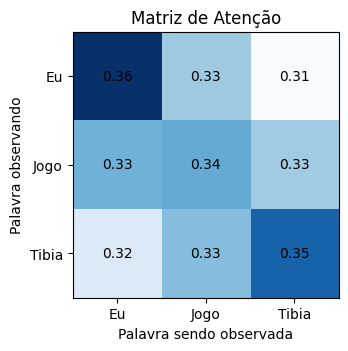

In [ ]:
# Visualização
plt.subplot(1, 2, 2)
plt.imshow(attention_weights, cmap='Blues')
plt.title('Matriz de Atenção')
plt.xlabel('Palavra sendo observada')
plt.ylabel('Palavra observando')
plt.xticks(range(3), palavras)
plt.yticks(range(3), palavras)

# Adicionar valores na matriz
for i in range(3):
    for j in range(3):
        plt.text(j, i, f'{attention_weights[i,j]:.2f}',
                ha='center', va='center', color='white' if attention_weights[i,j] > 0.5 else 'black')

plt.tight_layout()
plt.show()

In [ ]:
class ScaledDotProductAttention(nn.Module):
    """
    Scaled Dot-Product Attention
    - scores = (Q @ K^T) / sqrt(d_k)
    - aplica máscara (True = permitido; False = bloquear) ANTES do softmax
    - softmax -> dropout -> @ V
    """
    def __init__(self, d_k: int, dropout: float = 0.1):
        super().__init__()
        self.scale = 1.0 / math.sqrt(d_k)
        self.drop = nn.Dropout(dropout)

    def forward(self, Q: torch.Tensor, K: torch.Tensor, V: torch.Tensor,
                mask: Optional[torch.Tensor] = None) -> Tuple[torch.Tensor, torch.Tensor]:
        # Q,K,V: [B, H, T, d_k]; scores: [B, H, T, T]
        scores = torch.matmul(Q, K.transpose(-2, -1)) * self.scale
        if mask is not None:
            # mask: True = pode atender; False = bloquear -> -inf
            # scores e mask devem ser broadcastáveis para [B, H, T, T]
            scores = scores.masked_fill(~mask, float('-inf'))

        attn = F.softmax(scores, dim=-1)
        attn = self.drop(attn)
        out  = torch.matmul(attn, V)  # [B, H, T, d_k]
        return out, attn

### **6. Implementação de Multi-Head Attention**

Expandimos a ideia de atenção para **múltiplas cabeças**. Cada cabeça observa o contexto por uma “lente” diferente: algumas capturam dependências locais, outras relações de longo alcance ou padrões de estilo.
  
Depois, concatenamos os resultados de todas as cabeças e projetamos de volta para a dimensão $d_{\text{model}}$, mantendo o formato $[B, T, d_{\text{model}}]$, o que garante compatibilidade com as conexões residuais.  

$$
\text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1, \ldots, \text{head}_h)W^O
$$

com  

$$
\text{head}_i = \text{Attention}(QW_i^Q, KW_i^K, VW_i^V)
$$

$\text{onde:}$ <p>
$\quad h$ número de cabeças de atenção <p>
$\quad W_i^Q, W_i^K, W_i^V$ projeções aprendíveis para consultas, chaves e valores <p>
$\quad W^O$ projeção final para voltar à dimensão $d_{model}.$  <p>

> 💡 **Intuição:**  
> - cada cabeça funciona como uma **lente fotográfica** diferente:  
>   - uma aproxima,  
>   - outra amplia o campo,  
>   - outra realça contraste.  
>   
> O conjunto das lentes oferece ao modelo uma **visão mais rica e complementar** do contexto.


In [ ]:
palavras = ['O', 'gato', 'brinca', 'com', 'o', 'cachorro']

# Parâmetros
d_model = 8
n_heads = 2
seq_len = len(palavras)

In [ ]:
# Criando embeddings
word_embeddings = torch.randn(seq_len, d_model) * 0.2
word_embeddings

tensor([[ 0.3854,  0.2975,  0.1801, -0.4211,  0.1357, -0.2469, -0.0086, -0.3209],
        [-0.1504,  0.3297, -0.0785, -0.2807, -0.1456, -0.1119, -0.1538,  0.1525],
        [ 0.3285, -0.0319, -0.0995,  0.0879, -0.1516,  0.2157,  0.1602,  0.3361],
        [ 0.2558,  0.2593,  0.1221,  0.2669, -0.0463,  0.0084, -0.0503,  0.1720],
        [-0.2769, -0.1742, -0.0447,  0.3435,  0.0638, -0.0849,  0.0611, -0.1549],
        [-0.3115,  0.1991, -0.1760, -0.1202, -0.2548,  0.4246, -0.2469, -0.0976]])

In [ ]:
x = word_embeddings + torch.tensor(pe, dtype=torch.float32)  # soma PE
x = x.unsqueeze(0)  # adiciona dimensão batch
print("Shape do input:", x.shape)

Shape do input: torch.Size([1, 6, 8])


In [ ]:
d_k = d_model // n_heads

# Projeções Q, K, V
W_Q = nn.Linear(d_model, d_model, bias=False)
W_K = nn.Linear(d_model, d_model, bias=False)
W_V = nn.Linear(d_model, d_model, bias=False)

In [ ]:
W_V

Linear(in_features=8, out_features=8, bias=False)

In [ ]:
Q = W_Q(x)   # (batch, seq_len, d_model)
K = W_K(x)
V = W_V(x)

In [ ]:
Q

tensor([[[-0.0723, -0.3228, -0.2324, -0.1968, -0.6544,  0.1160, -0.3855,
          -0.6461],
         [ 0.2792, -0.4759, -0.2041,  0.2548, -0.8850, -0.0858, -0.3099,
          -0.4849],
         [ 0.7387, -0.5409, -0.0472,  0.8400, -0.7165, -0.3874, -0.1401,
          -0.2056],
         [ 0.3792, -0.5341, -0.1229,  0.3502, -0.4123, -0.1988, -0.4610,
          -0.3438],
         [ 0.0669, -0.6469, -0.3093, -0.2180, -0.0012,  0.0724, -0.8719,
          -0.3167],
         [ 0.0342, -0.7356, -0.4705, -0.4020, -0.3959,  0.4237, -0.8191,
          -0.6479]]], grad_fn=<UnsafeViewBackward0>)

In [ ]:
# Split em heads: (batch, n_heads, seq_len, d_k)
def split_heads(tensor):
    b, seq_len, d_model = tensor.shape
    return tensor.view(b, seq_len, n_heads, d_k).transpose(1, 2)

Qh = split_heads(Q)
Kh = split_heads(K)
Vh = split_heads(V)

In [ ]:
Qh

tensor([[[[-0.0723, -0.3228, -0.2324, -0.1968],
          [ 0.2792, -0.4759, -0.2041,  0.2548],
          [ 0.7387, -0.5409, -0.0472,  0.8400],
          [ 0.3792, -0.5341, -0.1229,  0.3502],
          [ 0.0669, -0.6469, -0.3093, -0.2180],
          [ 0.0342, -0.7356, -0.4705, -0.4020]],

         [[-0.6544,  0.1160, -0.3855, -0.6461],
          [-0.8850, -0.0858, -0.3099, -0.4849],
          [-0.7165, -0.3874, -0.1401, -0.2056],
          [-0.4123, -0.1988, -0.4610, -0.3438],
          [-0.0012,  0.0724, -0.8719, -0.3167],
          [-0.3959,  0.4237, -0.8191, -0.6479]]]],
       grad_fn=<TransposeBackward0>)

In [ ]:
# Atenção em cada cabeça
scores = torch.matmul(Qh, Kh.transpose(-2, -1)) / torch.sqrt(torch.tensor(d_k, dtype=torch.float32))
attn = F.softmax(scores, dim=-1)  # (batch, n_heads, seq_len, seq_len)
out = torch.matmul(attn, Vh)      # (batch, n_heads, seq_len, d_k)

# Concatenar cabeças
out = out.transpose(1, 2).contiguous().view(1, seq_len, d_model)
out

tensor([[[-0.1934, -0.0486,  0.0540, -0.3807,  0.3562,  0.1158,  0.1296,
          -0.4435],
         [-0.1952, -0.0724,  0.0180, -0.3497,  0.3550,  0.1162,  0.1214,
          -0.4373],
         [-0.2000, -0.1043, -0.0301, -0.3089,  0.3526,  0.1141,  0.1113,
          -0.4260],
         [-0.1988, -0.0771,  0.0110, -0.3456,  0.3557,  0.1140,  0.1292,
          -0.4406],
         [-0.1964, -0.0489,  0.0538, -0.3823,  0.3591,  0.1136,  0.1494,
          -0.4635],
         [-0.1941, -0.0414,  0.0653, -0.3907,  0.3601,  0.1163,  0.1503,
          -0.4674]]], grad_fn=<ViewBackward0>)

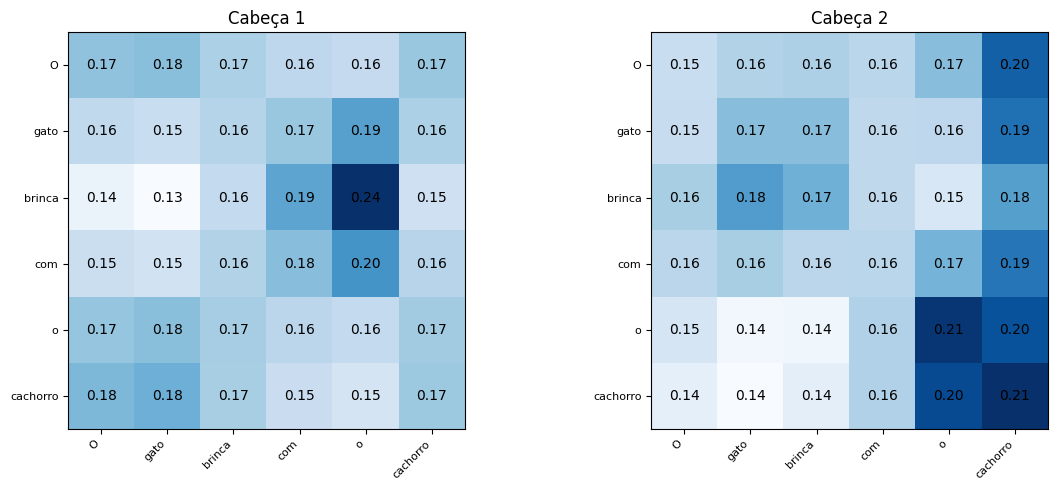

In [ ]:
attn_np = attn[0].detach().numpy()

fig, axes = plt.subplots(1, n_heads, figsize=(12, 5))
if n_heads == 1:
    axes = [axes]

for i in range(n_heads):
    axes[i].imshow(attn_np[i], cmap='Blues')
    axes[i].set_title(f'Cabeça {i+1}')
    axes[i].set_xticks(np.arange(seq_len))
    axes[i].set_yticks(np.arange(seq_len))
    axes[i].set_xticklabels(palavras, rotation=45, ha="right", fontsize=8)
    axes[i].set_yticklabels(palavras, fontsize=8)

    for row in range(seq_len):
        for col in range(seq_len):
            val = attn_np[i, row, col]
            axes[i].text(col, row, f'{val:.2f}',
                         ha='center', va='center')

plt.tight_layout()
plt.show()

In [ ]:
class MultiHeadAttention(nn.Module):
    """
    Multi-Head Attention:
    - Projeta x em Q, K, V para cada cabeça
    - Aplica atenção cabeça a cabeça (em paralelo)
    - Concatena e projeta de volta para d_model
    """
    def __init__(self, d_model: int, n_heads: int = 8, dropout: float = 0.1):
        super().__init__()
        assert d_model % n_heads == 0, "d_model deve ser divisível por n_heads"
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_k = d_model // n_heads

        # Projeções lineares para Q, K, V (sem bias por padrão em LMs)
        self.q_proj = nn.Linear(d_model, d_model, bias=False)
        self.k_proj = nn.Linear(d_model, d_model, bias=False)
        self.v_proj = nn.Linear(d_model, d_model, bias=False)

        # Projeção final após concatenação das cabeças
        self.out_proj = nn.Linear(d_model, d_model, bias=False)

        self.sdpa = ScaledDotProductAttention(self.d_k, dropout=dropout)
        self.attn_drop = nn.Dropout(dropout)
        self.proj_drop = nn.Dropout(dropout)

    def _split_heads(self, x: torch.Tensor) -> torch.Tensor:
        # [B, T, C] -> [B, heads, T, d_k]
        B, T, C = x.shape
        x = x.view(B, T, self.n_heads, self.d_k).transpose(1, 2)
        return x

    def _merge_heads(self, x: torch.Tensor) -> torch.Tensor:
        # [B, heads, T, d_k] -> [B, T, C]
        B, H, T, D = x.shape
        return x.transpose(1, 2).contiguous().view(B, T, H * D)

    def forward(self, x: torch.Tensor, mask: Optional[torch.Tensor] = None):
        # x: [B, T, C]
        Q = self._split_heads(self.q_proj(x))
        K = self._split_heads(self.k_proj(x))
        V = self._split_heads(self.v_proj(x))

        # Atenção por cabeça (com máscara causal/padding já expandida)
        y, attn = self.sdpa(Q, K, V, mask=mask)  # y: [B, heads, T, d_k]

        # Concatena cabeças e projeta de volta para d_model
        y = self._merge_heads(y)                 # [B, T, C]
        y = self.out_proj(y)
        y = self.proj_drop(y)

        return y, attn  # retornamos 'attn' para visualização posterior

### **7. Feed-Forward Network (FFN)**

Depois da atenção multi-cabeças, cada token já tem informações contextualizadas do restante da sequência. Mas ainda precisamos refinar cada posição individualmente, aumentando a capacidade de representação do modelo.
É aí que entra a Feed-Forward Network (FFN).

Ela é chamada de position-wise ML (Multi-Layer Perceptron) porque:

A mesma transformação é aplicada a cada posição do token independentemente.

*Não há troca de informação entre tokens nessa etapa (essa troca já foi feita na atenção).*

$$
\text{FFN}(x) = \text{Dropout}\!\left( W_2 \, \sigma(W_1 x + b_1) + b_2 \right)
$$

$\text{onde:}$  
$\quad x \;=\;$ vetor de entrada em uma posição <p>
$\quad W_1 \in \mathbb{R}^{d_{\text{model}} \times 4d_{\text{model}}},$  
$\quad W_2 \in \mathbb{R}^{4d_{\text{model}} \times d_{\text{model}}},$  
$\quad \sigma =$ função de ativação (GELU) <p>
$\quad b_1, b_2$ biases aprendíveis  

Usamos:  
- expansão de **4× em relação a $d_{model}$**,  
- ativação [**GELU**](https://medium.com/@shauryagoel/gelu-gaussian-error-linear-unit-4ec59fb2e47c) (padrão em LMs modernos)


In [ ]:
# domínio
x = np.linspace(-5, 5, 2000)
x

array([-5.       , -4.9949975, -4.989995 , ...,  4.989995 ,  4.9949975,
        5.       ])

In [ ]:
# ReLU
relu = np.maximum(0.0, x)
relu



array([0.       , 0.       , 0.       , ..., 4.989995 , 4.9949975,
       5.       ])

In [ ]:
# GELU (aproximação com tanh de Hendrycks & Gimpel)
gelu = 0.5 * x * (1.0 + np.tanh(np.sqrt(2/np.pi) * (x + 0.044715 * x**3)))
gelu

array([-2.29179620e-07, -2.37040867e-07, -2.45158403e-07, ...,
        4.98999475e+00,  4.99499726e+00,  4.99999977e+00])

In [ ]:
# Derivadas numéricas
drelu = np.gradient(relu, x)
dgelu = np.gradient(gelu, x)

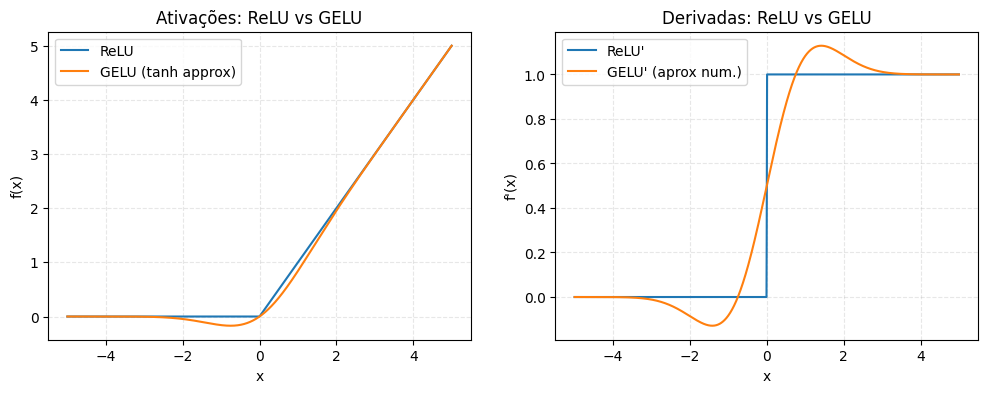

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Ativações
axes[0].plot(x, relu, label="ReLU")
axes[0].plot(x, gelu, label="GELU (tanh approx)")
axes[0].set_title("Ativações: ReLU vs GELU")
axes[0].set_xlabel("x")
axes[0].set_ylabel("f(x)")
axes[0].legend()
axes[0].grid(True, linestyle="--", alpha=0.3)

# Derivadas
axes[1].plot(x, drelu, label="ReLU'")
axes[1].plot(x, dgelu, label="GELU' (aprox num.)")
axes[1].set_title("Derivadas: ReLU vs GELU")
axes[1].set_xlabel("x")
axes[1].set_ylabel("f'(x)")
axes[1].legend()
axes[1].grid(True, linestyle="--", alpha=0.3)

plt.show()

In [ ]:
class FeedForward(nn.Module):
    """
    FFN posição-wise (mesma transformação aplicada a cada posição):
    - Expansão 4x
    - GELU (ou ReLU) como ativação
    - Dropout para regularização
    """
    def __init__(self, d_model: int, d_ff: Optional[int] = None, dropout: float = 0.1, activation: str = 'gelu'):
        super().__init__()
        d_ff = d_ff or 4 * d_model
        act = nn.GELU() if activation.lower() == 'gelu' else nn.ReLU(inplace=True)

        self.net = nn.Sequential(
            nn.Linear(d_model, d_ff),
            act,
            nn.Dropout(dropout),
            nn.Linear(d_ff, d_model),
            nn.Dropout(dropout),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)

### **8. Bloco Transformer Completo**

Juntamos tudo no bloco Transformer no estilo **Pre-LayerNorm**:  

1. Normalizamos, aplicamos a atenção multi-cabeças e somamos o residual.  
2. Normalizamos novamente, passamos pela FFN e somamos outro residual.  

In [ ]:
class TransformerBlock(nn.Module):
    """
    Bloco Transformer (estilo GPT) com:
    - Pre-LayerNorm -> estabilidade em redes profundas
    - Multi-Head Attention (com máscara causal/padding)
    - Residual + FFN posição-wise
    """
    def __init__(self, d_model: int, n_heads: int = 8, d_ff: Optional[int] = None,
                 dropout: float = 0.1, activation: str = 'gelu'):
        super().__init__()
        self.ln1 = nn.LayerNorm(d_model)
        self.mha = MultiHeadAttention(d_model, n_heads, dropout)
        self.ln2 = nn.LayerNorm(d_model)
        self.ffn = FeedForward(d_model, d_ff, dropout, activation)

    def forward(self, x: torch.Tensor, mask: Optional[torch.Tensor] = None):
        # 1) Atenção com normalização antes (Pre-LN) + residual
        h, attn = self.mha(self.ln1(x), mask=mask)
        x = x + h

        # 2) FFN com normalização antes (Pre-LN) + residual
        h = self.ffn(self.ln2(x))
        x = x + h

        return x, attn

### **9. Modelo Linguagem**

Montamos o modelo **auto-regressivo** com os seguintes componentes:  
- **embedding de tokens**,  
- **embedding posicionais**,  
- uma pilha de **blocos Transformer**,  
- **normalização final**,  
- e a **cabeça de linguagem** para previsão do próximo token.  

Ativamos **weight tying**, isto é, compartilhamos os pesos entre o embedding de entrada e a projeção final, reduzindo o número de parâmetros e favorecendo a generalização.  

$$
P(x_t \mid x_{<t}) = \text{softmax}(W \, h_t)
$$

$\text{onde:}$ <p>  
$\quad h_t$ representação do Transformer na posição <p>
$\quad W$ matriz de pesos (compartilhada com o embedding)  

Para geração de texto, usamos **amostragem com temperatura**:  

$$
P_i = \frac{\exp(z_i / T)}{\sum_j \exp(z_j / T)}
$$

$\text{onde:}$ <p>
$\quad z_i$ logit do token<p>
$\quad T$ temperatura de amostragem  

- Valores mais baixos ($0.5 \!-\! 0.7$) produzem saídas **mais conservadoras**,  
- Valores mais altos ($1.0 \!-\! 1.2$) aumentam a **diversidade**, mas com risco de perder coerência.  

Também podemos combinar com:  
- **top-p** ($0.9 \!-\! 0.95$): mantém apenas tokens dentro da massa de probabilidade cumulativa $p$,  
- **top-k** ($40 \!-\! 100$): limita a escolha aos $k$ tokens mais prováveis.  

In [ ]:
@dataclass
class AutoregressiveConfig:
    """Configurações do modelo."""
    vocab_size: int = vocab_size
    d_model: int = 512     # Dimensão do embedding
    n_heads: int = 8       # Cabeças de atenção
    n_layers: int = 6      # Camadas Transformer
    d_ff: int = 2048       # Dimensão do feed-forward
    max_len: int = 512     # Comprimento máximo da sequência
    dropout: float = 0.1
    activation: str = 'gelu'
    weight_tying: bool = True  # Compartilhar pesos embedding <-> output

In [ ]:
class AutoregressiveTransformer(nn.Module):
    """
    Modelo de linguagem auto-regressivo:
    - Embedding de tokens + PositionalEncoding (seno/cosseno)
    - Pilha de blocos Transformer (Pre-LN)
    - Cabeça de linguagem (weight tying opcional)
    - Forward retorna logits (+ loss opcional) e mapas de atenção
    - Generate com temperature/top-k/top-p/repetition penalty/eos/pad
    """
    def __init__(self, config: AutoregressiveConfig):
        super().__init__()
        self.config = config

        # Embedding de tokens (ID -> vetor)
        self.token_embedding = nn.Embedding(config.vocab_size, config.d_model)

        # Codificação posicional (ordem dos tokens)
        self.pos_encoding = PositionalEncoding(config.d_model, config.max_len)

        # Dropout inicial
        self.dropout = nn.Dropout(config.dropout)

        # Pilha de blocos Transformer
        self.blocks = nn.ModuleList([
            TransformerBlock(config.d_model, config.n_heads, config.d_ff,
                             config.dropout, config.activation)
            for _ in range(config.n_layers)
        ])

        # Normalização final + projeção para o vocabulário
        self.ln_final = nn.LayerNorm(config.d_model)
        self.lm_head = nn.Linear(config.d_model, config.vocab_size, bias=False)

        # Weight tying (compartilha pesos do embedding com a cabeça de linguagem)
        if config.weight_tying:
            self.token_embedding.weight = self.lm_head.weight

        # Inicialização
        self.apply(self._init_weights)

    def _init_weights(self, module):
        """Inicialização estilo GPT para estabilidade."""
        if isinstance(module, nn.Linear):
            nn.init.normal_(module.weight, 0.0, 0.02)
            if module.bias is not None:
                nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            nn.init.normal_(module.weight, 0.0, 0.02)
        elif isinstance(module, nn.LayerNorm):
            nn.init.zeros_(module.bias); nn.init.ones_(module.weight)

    def create_causal_mask(self, seq_len: int, device: torch.device) -> torch.Tensor:
        """
        Máscara causal triângulo inferior (permite olhar só para o passado):
        shape: [1, 1, T, T] com True onde PODE atender.
        """
        causal = torch.tril(torch.ones((seq_len, seq_len), device=device, dtype=torch.bool))
        return causal[None, None, :, :]  # [1, 1, T, T]

    def forward(self, idx: torch.Tensor, targets: Optional[torch.Tensor] = None, pad_id: Optional[int] = None):
        """
        idx:     [B, T]
        targets: [B, T]
        pad_id:  se informado, ignora padding na loss e na atenção
        """
        B, T = idx.shape

        # Sanidade
        max_token_id = torch.max(idx)
        if max_token_id >= self.config.vocab_size:
            raise ValueError(f"Token ID {max_token_id} excede vocab_size {self.config.vocab_size}")

        # Embedding (com escala) + PE + dropout
        x = self.token_embedding(idx) * math.sqrt(self.config.d_model)  # <<< escala recomendada
        x = self.pos_encoding(x)
        x = self.dropout(x)

        # Máscara causal [1,1,T,T]
        mask = self.create_causal_mask(T, idx.device)  # True = permitido

        # Máscara de padding (chaves) [B,1,1,T] -> broadcast para [B,1,T,T]
        if pad_id is not None:
            key_padding = (idx != pad_id).unsqueeze(1).unsqueeze(2)  # True = token válido
            mask = mask & key_padding

        # Pilha de blocos
        attns = []
        for block in self.blocks:
            x, a = block(x, mask)
            attns.append(a)

        # Camada final
        x = self.ln_final(x)
        logits = self.lm_head(x)  # [B, T, V]

        loss = None
        if targets is not None:
            ignore_idx = pad_id if pad_id is not None else -100
            loss = F.cross_entropy(
                logits.view(-1, logits.size(-1)),
                targets.view(-1),
                ignore_index=ignore_idx
            )

        return logits, loss, attns


    @torch.no_grad()
    def generate(self,
                 idx: torch.Tensor,
                 max_new_tokens: int = 100,
                 temperature: float = 1.0,
                 top_p: Optional[float] = None,
                 top_k: Optional[int] = None,
                 eos_id: Optional[int] = None,
                 repetition_penalty: float = 1.0,
                 return_new_only: bool = False,
                 pad_id: Optional[int] = None):
        """
        Geração auto-regressiva controlável:
        - temperature: 0 => greedy; >0 => amostragem
        - top_k/top_p (nucleus): corta cauda da distribuição
        - repetition_penalty: penaliza tokens já vistos no contexto
        - eos_id: para antecipar parada assim que [SEP] for gerado
        - pad_id: para formar máscara de atenção (se houver padding no prompt)
        """
        self.eval()

        temperature = max(temperature, 1e-8)
        if top_p is not None: top_p = float(min(max(top_p, 0.0), 1.0))
        if top_k is not None: top_k = int(max(1, top_k))

        B, _ = idx.size()
        new_tokens = []

        # Sanidade de entrada
        max_input_id = torch.max(idx)
        if max_input_id >= self.config.vocab_size:
            raise ValueError(f"Input token ID {max_input_id} excede vocab_size {self.config.vocab_size}")

        for _ in range(max_new_tokens):
            # Contexto limitado ao tamanho máximo do modelo
            ctx = idx[:, -self.config.max_len:]

            # Forward para obter logits do próximo token
            logits, _, _ = self(ctx, pad_id=pad_id)
            logits = logits[:, -1, :]  # só o último passo [B, V]

            # Penaliza repetição (reduz prob. de tokens já usados)
            if repetition_penalty != 1.0:
                for b in range(B):
                    seq = ctx[b] if pad_id is None else ctx[b][ctx[b] != pad_id]
                    uniq = torch.unique(seq)
                    uniq = uniq[uniq < logits.size(-1)]
                    # Se o logit é positivo, divide; se negativo, multiplica
                    logits[b, uniq] = torch.where(
                        logits[b, uniq] > 0,
                        logits[b, uniq] / repetition_penalty,
                        logits[b, uniq] * repetition_penalty
                    )

            # Greedy (temperature == 0) vs Sampling
            if temperature == 0:
                next_token = torch.argmax(logits, dim=-1, keepdim=True)
            else:
                logits = logits / temperature

                # Top-k: mantém apenas os k melhores
                if top_k is not None and top_k < logits.size(-1):
                    v, _ = torch.topk(logits, top_k, dim=-1)
                    logits[logits < v[..., -1, None]] = -float('inf')

                # Top-p (nucleus): mantém a menor banda de tokens cuja soma de probs >= p
                if top_p is not None and 0.0 < top_p < 1.0:
                    sorted_logits, sorted_idx = torch.sort(logits, descending=True)
                    sorted_probs = F.softmax(sorted_logits, dim=-1)
                    cumprobs = torch.cumsum(sorted_probs, dim=-1)

                    # Mascara tudo que ultrapassa p (preserva pelo menos um token)
                    cutoff = cumprobs > top_p
                    cutoff[..., 1:] = cutoff[..., :-1].clone()
                    cutoff[..., 0] = False
                    sorted_logits[cutoff] = -float('inf')
                    logits = logits.scatter(1, sorted_idx, sorted_logits)

                probs = F.softmax(logits, dim=-1)
                if torch.isnan(probs).any():
                    # fallback defensivo
                    next_token = torch.argmax(logits, dim=-1, keepdim=True)
                else:
                    next_token = torch.multinomial(probs, num_samples=1)

            # Sanidade do token
            if torch.max(next_token) >= self.config.vocab_size:
                break

            # Concatena novo token ao contexto
            idx = torch.cat([idx, next_token], dim=1)
            new_tokens.append(next_token)

            # Parada se todos geraram EOS
            if eos_id is not None and (next_token == eos_id).all():
                break

        if not new_tokens:
            return idx if not return_new_only else torch.empty((B, 0), dtype=idx.dtype, device=idx.device)

        out = torch.cat(new_tokens, dim=1)
        return out if return_new_only else idx

In [ ]:
# Criar modelo
config = AutoregressiveConfig(
    vocab_size=vocab_size,
    d_model=512,
    n_heads=8,
    n_layers=6,
    d_ff=2048,
    max_len=512,
    dropout=0.1,
    weight_tying=True
)

# Inicialização do Modelo
model = AutoregressiveTransformer(config).to(device)

### **10. Preparação dos Dados**

Tokenizamos o corpus completo, convertendo o texto em **IDs inteiros** e depois dividimos em conjuntos de treino e validação (no código, 80% / 20%).  

Para treinar de forma **auto-regressiva**, amostramos janelas de comprimento $block\_size$ usando a função `get_batch`:  

- cada batch contém pares $(x, y)$,  
- onde $x$ são os tokens de entrada,  
- e $y$ são os mesmos tokens deslocados em 1 posição, ou seja, os alvos da predição.  

$$
x = [x_t, \ldots, x_{t+block\_size-1}], \quad
y = [x_{t+1}, \ldots, x_{t+block\_size}]
$$  

Aumentar $block\_size$ fornece **mais contexto** para cada predição, mas o custo de memória e tempo cresce de forma aproximadamente **quadrática** com o tamanho da janela, exigindo um equilíbrio cuidadoso.  

In [ ]:
# Tokenizar o corpus completo
print("Tokenizando corpus...")
text_ids = tokenizer.encode(textos)
print(f"Total de tokens: {len(text_ids):,}")

# Converter para tensor
data = torch.tensor(text_ids, dtype=torch.long)

# Dividir em treino (75%) e validação (25%)
n_train = int(0.75 * len(data))
train_data = data[:n_train]
val_data   = data[n_train:]

print("Dados preparados:")
print(f"   Treino: {len(train_data):,} tokens")
print(f"   Validação: {len(val_data):,} tokens")

Tokenizando corpus...
Total de tokens: 118,298,407
Dados preparados:
   Treino: 88,723,805 tokens
   Validação: 29,574,602 tokens


### **11. Treinamento do Modelo**

O loop de treino vamos utilziar:  
- `AdamW` como otimizador,  
- `mixed precision` para acelerar e economizar memória,  
- `clipping de gradiente` para evitar explosões,  
- `CosineAnnealingWarmRestarts` como `scheduler` da taxa de aprendizado.  

Em intervalos regulares, calculamos a **perda média** em treino e validação (para reduzir variância) e salvamos o melhor modelo com base na menor *val\_loss*. A métrica principal é a **perplexidade (PPL)**: A **Perplexidad**e mede quão "surpreso" o modelo fica com o texto de teste. Valores menores indicam melhor performance.

$$
\text{PPL} = \exp(\text{loss})
$$  

Esperamos observar a `val\_loss` caindo ao longo do tempo e a perplexidade acompanhando essa queda.  

- Se a curva “achatar” cedo → ajuste a **taxa de aprendizado** ou o **agendamento**.  
- Se oscilar demais → aumente `eval_iters` para médias mais estáveis.


In [ ]:
def get_batch(split, batch_size=32, block_size=128):
    """Gera um batch de treino ou validação."""
    data = train_data if split == 'train' else val_data

    # Índices iniciais aleatórios
    ix = torch.randint(len(data) - block_size, (batch_size,))

    # Constrói entradas (x) e alvos (y)
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])

    return x.to(device), y.to(device)


@torch.no_grad()
def estimate_loss(model, eval_iters=200):
    """Calcula perda média em treino e validação."""
    model.eval()
    out = {}

    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss, _ = model(X, Y)   # <- ignora attn_weights
            losses[k] = loss.item()
        out[split] = losses.mean().item()   # <-- retorna float

    model.train()
    return out

In [ ]:
@torch.no_grad()
def calculate_perplexity(model, split, batch_size=32, block_size=128, n_batches=100):
    """Calcula perplexidade média."""
    model.eval()
    total_loss = 0.0

    for _ in range(n_batches):
        x, y = get_batch(split, batch_size, block_size)
        logits, loss, _ = model(x, y)
        total_loss += loss.item()

    avg_loss = total_loss / n_batches
    ppl = math.exp(avg_loss)  # perplexidade = e^(loss em nats)

    model.train()
    return ppl

In [ ]:
# Hiperparâmetros
batch_size    = 64
block_size    = 512
learning_rate = 3e-4
max_iters     = 20_000
eval_interval = 500
eval_iters    = 200
save_interval = 1_000

# Criar otimizador
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

In [ ]:
print("Iniciando o Treinamento do Modelo")

train_losses, val_losses, val_ppls = [], [], []
best_val_loss = float('inf')

# Inicializar GradScaler para mixed precision
scaler = GradScaler()

# Inicializa Cosine Learning Rate Scheduler
scheduler = CosineAnnealingWarmRestarts(
    optimizer,
    T_0=max_iters // 10,  # Primeiro ciclo: ~10% do treino
    T_mult=2,             # Dobra a cada restart
    eta_min=learning_rate / 100
)

for iter in tqdm(range(max_iters), desc="Treinando"):

    # Avaliação periódica
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss(model, eval_iters)
        train_losses.append(losses['train'])
        val_losses.append(losses['val'])

        # Calcular perplexidade no conjunto de validação
        val_ppl = calculate_perplexity(model, 'val', batch_size=32, block_size=block_size)
        val_ppls.append(val_ppl)

        print(f"\nIter {iter:5d} | Train: {losses['train']:.4f} | Val: {losses['val']:.4f} | PPL: {val_ppl:.2f}")

        # Salvar melhor modelo
        if losses['val'] < best_val_loss:
            best_val_loss = losses['val']
            if not math.isnan(best_val_loss):
                print(f"   Novo melhor modelo! Val Loss: {best_val_loss:.4f} | Perplexity: {val_ppl:.2f}")

                torch.save({
                    'iter': iter,
                    'model': model.state_dict(),
                    'optim': optimizer.state_dict(),
                    'train_loss': losses['train'],
                    'val_loss': losses['val'],
                    'val_perplexity': val_ppl,
                    'config': config.__dict__,
                    'tokenizer': "neuralmind/bert-large-portuguese-cased"
                }, '/content/drive/MyDrive/modelo_transforms/best_model.pt')

    # Checkpoint periódico
    if iter % save_interval == 0 and iter > 0:
        print(f"   Checkpoint salvo em iter {iter}")
        torch.save({
            'iter': iter,
            'model': model.state_dict(),
            'optim': optimizer.state_dict(),
            'train_losses': train_losses,
            'val_losses': val_losses,
            'config': config.__dict__  # <-- consistente
        }, f'/content/drive/MyDrive/modelo_transforms/checkpoint_{iter}.pt')

    # Batch de treino
    xb, yb = get_batch('train', batch_size, block_size)

    # Forward + loss (mixed precision só na GPU)
    use_autocast = (device.type == 'cuda')
    with autocast(device_type='cuda', enabled=use_autocast):
        logits, loss, _ = model(xb, yb)

    # Backward
    optimizer.zero_grad(set_to_none=True)
    scaler.scale(loss).backward()

    # Clipping de gradientes
    scaler.unscale_(optimizer)  # Unscale antes do clipping
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # Optimizer step
    scaler.step(optimizer)
    scaler.update()

    # Step do scheduler por iteração
    scheduler.step(iter)

Iniciando o Treinamento do Modelo


Treinando:   0%|          | 0/20000 [00:00<?, ?it/s]


Iter     0 | Train: 10.3944 | Val: 10.3965 | PPL: 33168.01
   Novo melhor modelo! Val Loss: 10.3965 | Perplexity: 33168.01


Treinando:   2%|▎         | 500/20000 [01:39<51:47,  6.28it/s]


Iter   500 | Train: 5.1075 | Val: 5.3956 | PPL: 215.63
   Novo melhor modelo! Val Loss: 5.3956 | Perplexity: 215.63


Treinando:   5%|▌         | 1000/20000 [03:17<50:30,  6.27it/s]


Iter  1000 | Train: 4.5738 | Val: 4.8654 | PPL: 124.46
   Novo melhor modelo! Val Loss: 4.8654 | Perplexity: 124.46
   Checkpoint salvo em iter 1000


Treinando:   8%|▊         | 1500/20000 [04:58<49:12,  6.27it/s]


Iter  1500 | Train: 4.3708 | Val: 4.6760 | PPL: 101.76
   Novo melhor modelo! Val Loss: 4.6760 | Perplexity: 101.76


Treinando:  10%|█         | 2000/20000 [06:36<47:48,  6.28it/s]


Iter  2000 | Train: 4.3511 | Val: 4.6482 | PPL: 97.80
   Novo melhor modelo! Val Loss: 4.6482 | Perplexity: 97.80
   Checkpoint salvo em iter 2000


Treinando:  12%|█▎        | 2500/20000 [08:16<46:28,  6.28it/s]


Iter  2500 | Train: 4.0829 | Val: 4.4079 | PPL: 71.61
   Novo melhor modelo! Val Loss: 4.4079 | Perplexity: 71.61


Treinando:  15%|█▌        | 3000/20000 [09:54<45:11,  6.27it/s]


Iter  3000 | Train: 3.8907 | Val: 4.1846 | PPL: 55.78
   Novo melhor modelo! Val Loss: 4.1846 | Perplexity: 55.78
   Checkpoint salvo em iter 3000


Treinando:  18%|█▊        | 3500/20000 [11:34<43:51,  6.27it/s]


Iter  3500 | Train: 3.8072 | Val: 4.0849 | PPL: 49.03
   Novo melhor modelo! Val Loss: 4.0849 | Perplexity: 49.03


Treinando:  20%|██        | 4000/20000 [13:12<42:35,  6.26it/s]


Iter  4000 | Train: 3.7042 | Val: 3.9960 | PPL: 45.23
   Novo melhor modelo! Val Loss: 3.9960 | Perplexity: 45.23
   Checkpoint salvo em iter 4000


Treinando:  22%|██▎       | 4500/20000 [14:51<41:08,  6.28it/s]


Iter  4500 | Train: 3.6739 | Val: 3.9317 | PPL: 43.10
   Novo melhor modelo! Val Loss: 3.9317 | Perplexity: 43.10


Treinando:  25%|██▌       | 5000/20000 [16:29<39:53,  6.27it/s]


Iter  5000 | Train: 3.6170 | Val: 3.9119 | PPL: 42.03
   Novo melhor modelo! Val Loss: 3.9119 | Perplexity: 42.03
   Checkpoint salvo em iter 5000


Treinando:  28%|██▊       | 5500/20000 [18:09<38:28,  6.28it/s]


Iter  5500 | Train: 3.6260 | Val: 3.9006 | PPL: 40.82
   Novo melhor modelo! Val Loss: 3.9006 | Perplexity: 40.82


Treinando:  30%|███       | 6000/20000 [19:47<37:11,  6.27it/s]


Iter  6000 | Train: 3.6098 | Val: 3.8968 | PPL: 40.78
   Novo melhor modelo! Val Loss: 3.8968 | Perplexity: 40.78
   Checkpoint salvo em iter 6000


Treinando:  33%|███▎      | 6501/20000 [21:44<20:25:04,  5.45s/it]


Iter  6500 | Train: 3.6362 | Val: 3.9254 | PPL: 40.88


Treinando:  35%|███▌      | 7000/20000 [23:04<34:34,  6.27it/s]


Iter  7000 | Train: 3.5491 | Val: 3.8452 | PPL: 39.59
   Novo melhor modelo! Val Loss: 3.8452 | Perplexity: 39.59
   Checkpoint salvo em iter 7000


Treinando:  38%|███▊      | 7500/20000 [24:43<33:10,  6.28it/s]


Iter  7500 | Train: 3.5222 | Val: 3.8227 | PPL: 37.86
   Novo melhor modelo! Val Loss: 3.8227 | Perplexity: 37.86


Treinando:  40%|████      | 8000/20000 [26:21<31:54,  6.27it/s]


Iter  8000 | Train: 3.4908 | Val: 3.7924 | PPL: 36.28
   Novo melhor modelo! Val Loss: 3.7924 | Perplexity: 36.28
   Checkpoint salvo em iter 8000


Treinando:  42%|████▎     | 8500/20000 [28:00<30:31,  6.28it/s]


Iter  8500 | Train: 3.4317 | Val: 3.7445 | PPL: 34.65
   Novo melhor modelo! Val Loss: 3.7445 | Perplexity: 34.65


Treinando:  45%|████▌     | 9000/20000 [29:39<29:16,  6.26it/s]


Iter  9000 | Train: 3.4003 | Val: 3.7233 | PPL: 34.12
   Novo melhor modelo! Val Loss: 3.7233 | Perplexity: 34.12
   Checkpoint salvo em iter 9000


Treinando:  48%|████▊     | 9500/20000 [31:18<27:57,  6.26it/s]


Iter  9500 | Train: 3.3891 | Val: 3.6907 | PPL: 32.78
   Novo melhor modelo! Val Loss: 3.6907 | Perplexity: 32.78


Treinando:  50%|█████     | 10000/20000 [32:56<26:35,  6.27it/s]


Iter 10000 | Train: 3.3650 | Val: 3.6818 | PPL: 32.25
   Novo melhor modelo! Val Loss: 3.6818 | Perplexity: 32.25
   Checkpoint salvo em iter 10000


Treinando:  52%|█████▎    | 10500/20000 [34:36<25:13,  6.28it/s]


Iter 10500 | Train: 3.3295 | Val: 3.6599 | PPL: 31.32
   Novo melhor modelo! Val Loss: 3.6599 | Perplexity: 31.32


Treinando:  55%|█████▌    | 11000/20000 [36:14<23:55,  6.27it/s]


Iter 11000 | Train: 3.3403 | Val: 3.6392 | PPL: 30.81
   Novo melhor modelo! Val Loss: 3.6392 | Perplexity: 30.81
   Checkpoint salvo em iter 11000


Treinando:  57%|█████▊    | 11500/20000 [37:53<22:38,  6.26it/s]


Iter 11500 | Train: 3.3115 | Val: 3.6224 | PPL: 31.14
   Novo melhor modelo! Val Loss: 3.6224 | Perplexity: 31.14


Treinando:  60%|██████    | 12000/20000 [39:31<21:16,  6.27it/s]


Iter 12000 | Train: 3.2817 | Val: 3.6087 | PPL: 30.58
   Novo melhor modelo! Val Loss: 3.6087 | Perplexity: 30.58
   Checkpoint salvo em iter 12000


Treinando:  62%|██████▎   | 12500/20000 [41:11<19:58,  6.26it/s]


Iter 12500 | Train: 3.2660 | Val: 3.6013 | PPL: 30.45
   Novo melhor modelo! Val Loss: 3.6013 | Perplexity: 30.45


Treinando:  65%|██████▌   | 13000/20000 [42:49<18:38,  6.26it/s]


Iter 13000 | Train: 3.3064 | Val: 3.5958 | PPL: 29.91
   Novo melhor modelo! Val Loss: 3.5958 | Perplexity: 29.91
   Checkpoint salvo em iter 13000


Treinando:  68%|██████▊   | 13501/20000 [44:46<9:49:57,  5.45s/it]


Iter 13500 | Train: 3.2687 | Val: 3.6030 | PPL: 29.81


Treinando:  70%|███████   | 14000/20000 [46:05<15:55,  6.28it/s]


Iter 14000 | Train: 3.2713 | Val: 3.6030 | PPL: 30.04
   Checkpoint salvo em iter 14000


Treinando:  73%|███████▎  | 14501/20000 [48:01<8:19:22,  5.45s/it]


Iter 14500 | Train: 3.3352 | Val: 3.6533 | PPL: 31.68


Treinando:  75%|███████▌  | 15000/20000 [49:21<13:17,  6.27it/s]


Iter 15000 | Train: 3.3217 | Val: 3.6324 | PPL: 30.96
   Checkpoint salvo em iter 15000


Treinando:  78%|███████▊  | 15501/20000 [51:17<6:48:57,  5.45s/it]


Iter 15500 | Train: 3.3034 | Val: 3.6292 | PPL: 31.04


Treinando:  80%|████████  | 16000/20000 [52:37<10:40,  6.25it/s]


Iter 16000 | Train: 3.2998 | Val: 3.6174 | PPL: 30.23
   Checkpoint salvo em iter 16000


Treinando:  82%|████████▎ | 16500/20000 [54:15<09:17,  6.27it/s]


Iter 16500 | Train: 3.2617 | Val: 3.5935 | PPL: 29.86
   Novo melhor modelo! Val Loss: 3.5935 | Perplexity: 29.86


Treinando:  85%|████████▌ | 17000/20000 [55:53<07:59,  6.26it/s]


Iter 17000 | Train: 3.2509 | Val: 3.5854 | PPL: 29.91
   Novo melhor modelo! Val Loss: 3.5854 | Perplexity: 29.91
   Checkpoint salvo em iter 17000


Treinando:  88%|████████▊ | 17500/20000 [57:32<06:38,  6.28it/s]


Iter 17500 | Train: 3.2482 | Val: 3.5690 | PPL: 29.24
   Novo melhor modelo! Val Loss: 3.5690 | Perplexity: 29.24


Treinando:  90%|█████████ | 18000/20000 [59:11<05:18,  6.28it/s]


Iter 18000 | Train: 3.2293 | Val: 3.5621 | PPL: 29.59
   Novo melhor modelo! Val Loss: 3.5621 | Perplexity: 29.59
   Checkpoint salvo em iter 18000


Treinando:  92%|█████████▎| 18500/20000 [1:00:50<03:59,  6.26it/s]


Iter 18500 | Train: 3.2061 | Val: 3.5562 | PPL: 29.03
   Novo melhor modelo! Val Loss: 3.5562 | Perplexity: 29.03


Treinando:  95%|█████████▌| 19000/20000 [1:02:28<02:39,  6.26it/s]


Iter 19000 | Train: 3.2081 | Val: 3.5422 | PPL: 28.26
   Novo melhor modelo! Val Loss: 3.5422 | Perplexity: 28.26
   Checkpoint salvo em iter 19000


Treinando:  98%|█████████▊| 19501/20000 [1:04:25<45:16,  5.44s/it]


Iter 19500 | Train: 3.2100 | Val: 3.5471 | PPL: 28.13


Treinando: 100%|█████████▉| 19999/20000 [1:05:45<00:00,  6.27it/s]


Iter 19999 | Train: 3.2021 | Val: 3.5342 | PPL: 28.00
   Novo melhor modelo! Val Loss: 3.5342 | Perplexity: 28.00


Treinando: 100%|██████████| 20000/20000 [1:06:03<00:00,  5.05it/s]


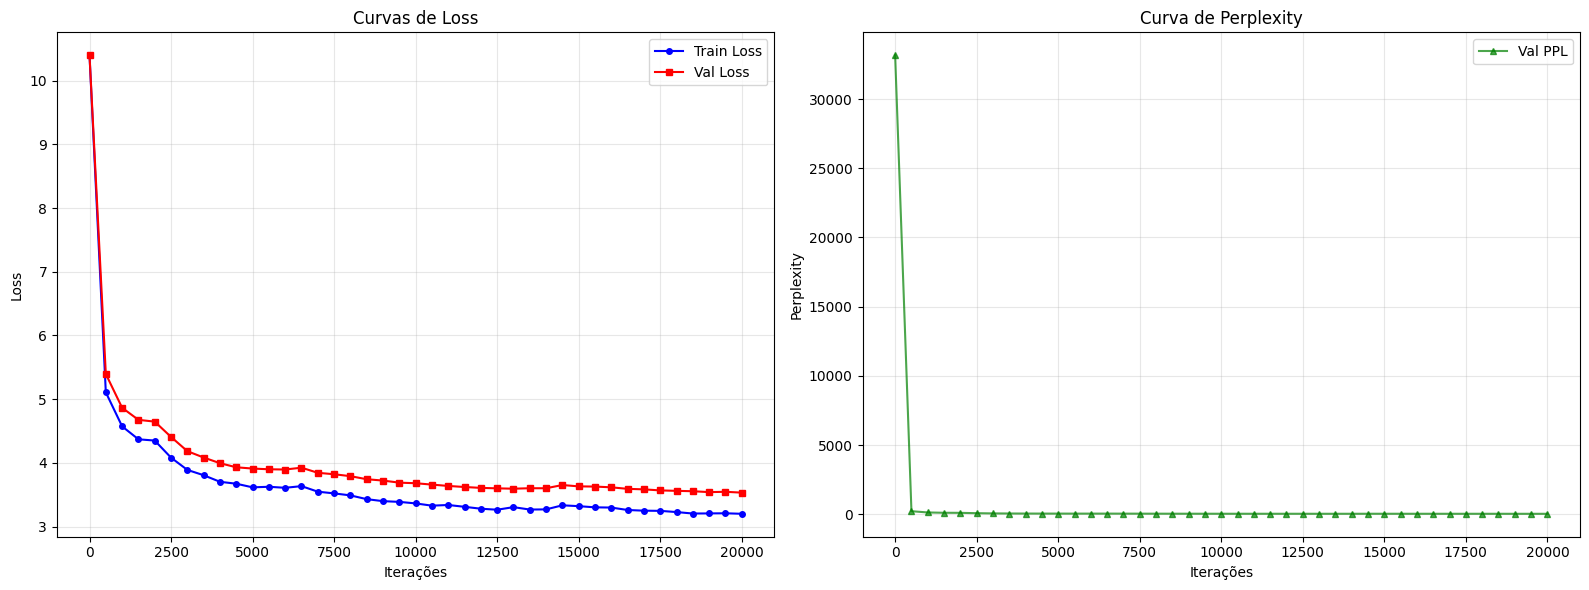

In [ ]:
steps = np.arange(len(train_losses)) * eval_interval

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Losses
axes[0].plot(steps, train_losses, 'b-', label='Train Loss', marker='o', markersize=4)
axes[0].plot(steps, val_losses, 'r-', label='Val Loss', marker='s', markersize=4)

# Labels e título (Losses)
axes[0].set_xlabel('Iterações')
axes[0].set_ylabel('Loss')
axes[0].set_title('Curvas de Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Perplexity
axes[1].plot(steps, val_ppls, 'g-', label='Val PPL', marker='^', markersize=4, alpha=0.7)

# Labels e título (Perplexity)
axes[1].set_xlabel('Iterações')
axes[1].set_ylabel('Perplexity')
axes[1].set_title('Curva de Perplexity')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Depois, validamos a geração utilizando **prompts curtos em diferentes temperaturas estilos** para compara-los.

**Temperature — Controle de Aleatoriedade**
| Faixa   | Efeito principal                                   | Uso recomendado       |
|---------|----------------------------------------------------|-----------------------|
| 0.0–0.3 | Quase determinístico, previsível                   | Tarefas de precisão   |
| 0.5–0.7 | Consistente, com variação leve                     | Respostas seguras     |
| 0.8–1.0 | Equilíbrio entre criatividade e coerência          | Padrão recomendado    |
| 1.0–1.2 | Mais criatividade e surpresa, risco de incoerência | Texto criativo        |
| >1.5    | Saída caótica, pouco útil                          | Evitar                |


**Repetition Penalty — Controle de Repetição**
| Valor   | Efeito principal                          | Uso recomendado       |
|---------|-------------------------------------------|-----------------------|
| 1.0     | Sem penalização, repetições naturais      | Base                  |
| 1.1–1.3 | Reduz repetição moderadamente             | Recomendado           |
| 1.4–1.6 | Penalização forte, pode quebrar fluidez   | Casos específicos     |
| >1.8    | Compromete coerência semântica            | Evitar                |

In [ ]:
# Teste de geração com diferentes prompts e temperaturas
test_prompts = [
    "Astronomia é",
    "O gato subiu no telhado",
    "Ciencia de Dados",
    "Em 2001",
    "O Brasil"
]

# Defina as temperaturas que deseja testar em cada prompt
temperatures = [0.8, 1.0, 1.2]

for prompt in test_prompts:
    print(f"\nPrompt: '{prompt}'")
    print("-" * 60)

    # Codificar prompt
    start_ids = tokenizer.encode(prompt, )
    x = torch.tensor([start_ids], dtype=torch.long).to(device)

    # Gerar para cada temperatura
    for temp in temperatures:
        print(f"\nTemperatura: {temp}")

        with torch.no_grad():
            generated_ids = model.generate(
                x,
                max_new_tokens=20,
                temperature=max(0.1, min(2.0, float(temp))),  # clamp defensivo
                top_k=50,
                top_p=0.9,
                repetition_penalty=1.1,
                eos_id=tokenizer.eos_id,
                pad_id=tokenizer.pad_id
            )
        # Decodificar
        print(tokenizer.decode(generated_ids[0].tolist()))


Prompt: 'Astronomia é'
------------------------------------------------------------

Temperatura: 0.8
Astronomia é um termo usado para designar o gênero botânico de orquídeas, cujos membros são frequentemente confundidos com

Temperatura: 1.0
Astronomia é composto por sete elementos, divididos em quatro níveis : O nome " Baiko " pode ser derivado de

Temperatura: 1.2
Astronomia é o primeiro projeto que teve como objetivo a criação de uma rede de rádios locais. Os projetos dos tele

Prompt: 'O gato subiu no telhado'
------------------------------------------------------------

Temperatura: 0.8
O gato subiu no telhado da casa e, após sua morte, o grupo foi rebatizado como " The Troopers of

Temperatura: 1.0
O gato subiu no telhado e as paredes não voltaram, sendo então mais tarde substituídas pelos tapetes de couro.

Temperatura: 1.2
O gato subiu no telhado em 2 de Fevereiro. No mesmo dia, com apenas 30 anos, as duas alas da velha gara

Prompt: 'Ciencia de Dados'
-----------------------

### **12. Visualização de Attention Patterns**

Visualizamos os mapas de atenção para compreender como o modelo distribui foco ao longo da sequência. Diagonais marcadas sugerem atenção local, em que cada token se relaciona principalmente com seus vizinhos, enquanto colunas verticais revelam “âncoras” semânticas capazes de atrair a atenção de grande parte da sequência. Esses padrões contribuem tanto para a interpretabilidade quanto para orientar decisões de ajuste fino.

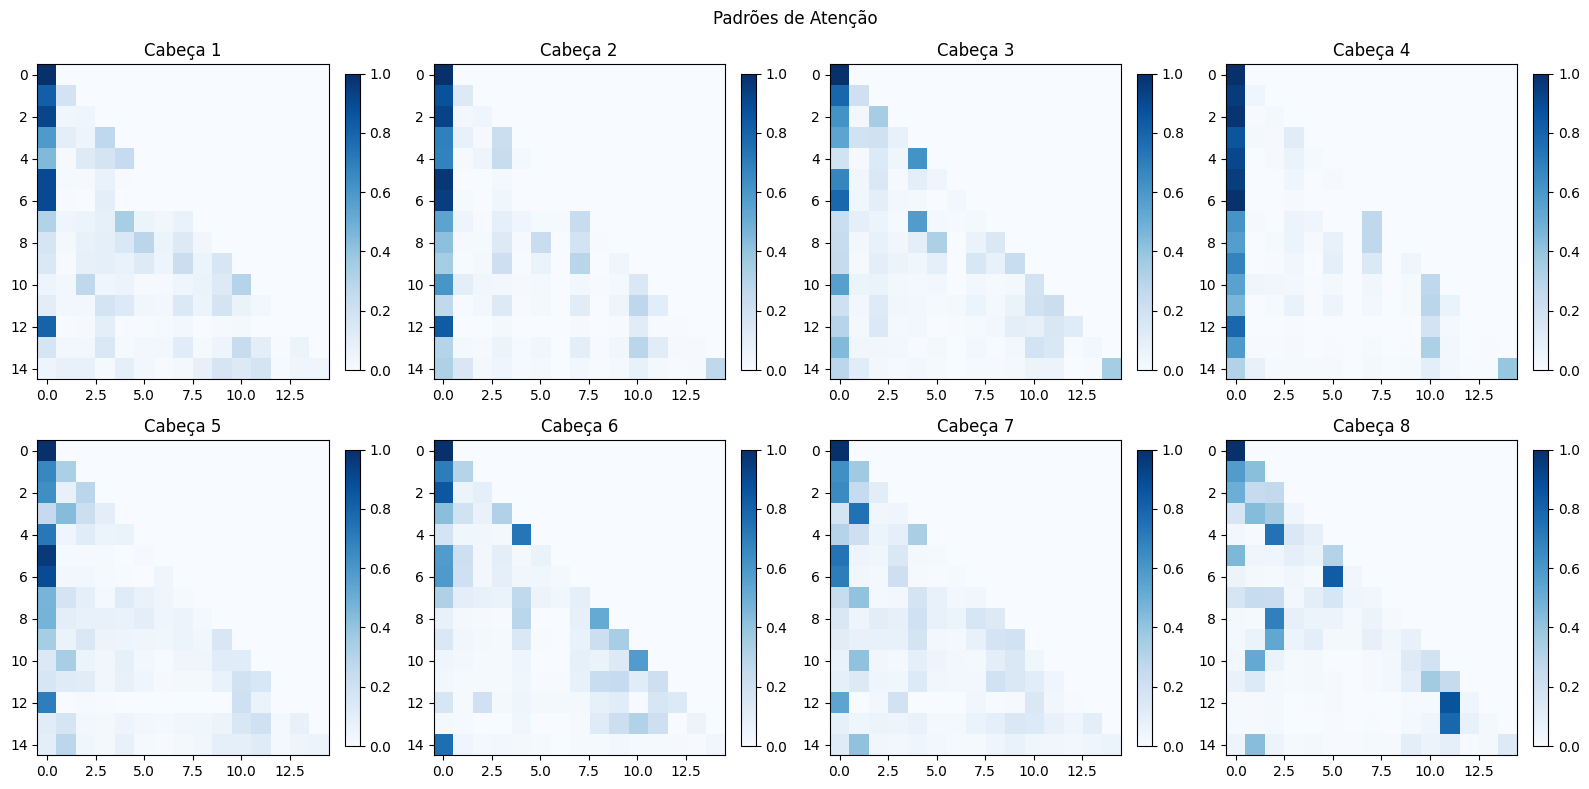

In [ ]:
# Visualizar padrões de atenção da última camada
sample_text = "O gato subiu no telhado ontem à noite sozinho porque estava assustado."
encoded = tokenizer.encode(sample_text)
sample_ids = tokenizer.encode(sample_text)[:20]
x_sample = torch.tensor([sample_ids], dtype=torch.long).to(device)

with torch.no_grad():
    _, _, attn_weights_all = model(x_sample)

last_layer_attn = attn_weights_all[-1][0].cpu()  # [n_heads, seq_len, seq_len]

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for head in range(min(8, last_layer_attn.shape[0])):
    attn = last_layer_attn[head].numpy()
    im = axes[head].imshow(attn, cmap='Blues', aspect='auto')
    axes[head].set_title(f'Cabeça {head+1}')
    plt.colorbar(im, ax=axes[head], fraction=0.046)

plt.suptitle('Padrões de Atenção')
plt.tight_layout()
plt.show()

### **13. Avaliação e Métricas**

Com o treino concluído, avaliamos a perplexidade nos conjuntos de treino e validação. Valores mais baixos indicam melhor desempenho, embora o valor absoluto dependa da tokenização e da natureza da tarefa. O aspecto essencial é acompanhar a tendência e comparar resultados entre execuções que utilizam a mesma configuração.

In [ ]:
# Calcular perplexidade final
train_ppl = calculate_perplexity(model, 'train')
val_ppl = calculate_perplexity(model, 'val')
print(f"Perplexidade Treino: {train_ppl:.2f}")
print(f"Perplexidade Validação: {val_ppl:.2f}")

Perplexidade Treino: 23.42
Perplexidade Validação: 34.08


Em seguida, salvamos os artefatos: o modelo completo em formato `.pt`, os pesos em arquivos `*_weights.pt` e a configuração em JSON. Incluir um timestamp ou hash na versão facilita a organização das execuções. Na configuração também registramos informações como o nome do tokenizer, o tamanho do vocabulário (`vocab_size`) e as métricas obtidas.

In [ ]:
# Salvar checkpoint final completo
final_checkpoint = {
    'model_state_dict': model.state_dict(),
    'config': config.__dict__,
    'tokenizer': "neuralmind/bert-large-portuguese-cased",
    'vocab_size': vocab_size,
    'training_history': {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'best_val_loss': best_val_loss,
        'final_train_ppl': train_ppl,
        'final_val_ppl': val_ppl,
        'total_iterations': max_iters
    },
    'hyperparameters': {
        'batch_size': batch_size,
        'block_size': block_size,
        'learning_rate': learning_rate,
        'max_iters': max_iters
    }
}
torch.save(final_checkpoint, '/content/drive/MyDrive/modelo_transforms/transformer_final.pt')

# Salvar apenas pesos
torch.save(model.state_dict(), '/content/drive/MyDrive/modelo_transforms/transformer_final_weights.pt')

In [ ]:
# Salvar configuração em JSON
with open('/content/drive/MyDrive/modelo_transforms/transformer_final_config.json', 'w') as f:
    json.dump({
        'config': config.__dict__,
        'tokenizer': "neuralmind/bert-large-portuguese-cased",
        'metrics': {
            'train_ppl': train_ppl,
            'val_ppl': val_ppl,
            'best_val_loss': best_val_loss
        }
    }, f, indent=2, default=str)

### **14. Carregamento e Execução do modelo treinado**

Para reutilização, basta carregar o modelo, recriar a configuração e o tokenizer e preparar o ambiente. A interface interativa permite experimentar diferentes prompts e ajustar parâmetros como `max_new_tokens` e `temperature`.

In [ ]:
def carregar_modelo(model_path = "/content/transformer_final.pt"):
    checkpoint = torch.load(model_path)

    config_dict = checkpoint['config']
    config = AutoregressiveConfig(**config_dict)

    model = AutoregressiveTransformer(config)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)

    tokenizer = BertTokenizerWrapper()

    return model, tokenizer

In [ ]:
def interface_interativa(model_path = '/content/transformer_final.pt'):
    """Interface de linha de comando para testar o modelo."""
    print("-"*60)
    print("CARREGANDO MODELO TRANSFORMER")

    try:
        model, tokenizer = carregar_modelo(model_path)
    except FileNotFoundError:
        print("Erro: Arquivo 'transformer_final.pt' não encontrado!")
        print("Por favor, treine o modelo primeiro.")
        return

    print("\nDigite 'sair' para encerrar")
    print("-"*60)

    while True:
        print("\n")
        prompt = input("Prompt: ").strip()

        if prompt.lower() == 'sair':
            print("\nEncerrando...")
            break

        if not prompt:
            print("Por favor, digite algum texto!")
            continue

        try:
            max_tokens_input = input("Máximo de tokens (padrão 100): ").strip()
            max_tokens = int(max_tokens_input) if max_tokens_input else 100

            temp_input = input("Temperatura 0.1-2.0 (padrão 0.8): ").strip()
            temperatura = float(temp_input) if temp_input else 0.8
        except ValueError:
            print("Valor inválido, usando padrões")
            max_tokens = 100
            temperatura = 0.8

        print(f"\nGerando com temperatura {temperatura}...")

        try:
            input_ids = tokenizer.encode(prompt)
            x = torch.tensor([input_ids], dtype=torch.long).to(device)

            with torch.no_grad():
                generated_ids = model.generate(
                    x,
                    max_new_tokens=int(max_tokens),
                    temperature=max(0.1, min(2.0, float(temperatura))),
                    top_k=50,
                    top_p=0.9,
                    repetition_penalty=1.1,
                    eos_id=tokenizer.eos_id,
                    pad_id=tokenizer.pad_id
                )

            texto_gerado = tokenizer.decode(generated_ids[0].tolist())
            print("\nTEXTO GERADO:")
            print(texto_gerado)

        except Exception as e:
            print(f"Erro na geração: {e}")

In [ ]:
interface_interativa(

)

------------------------------------------------------------
CARREGANDO MODELO TRANSFORMER

Digite 'sair' para encerrar
------------------------------------------------------------


Prompt: O Brasil é o país que 
Máximo de tokens (padrão 100): 50
Temperatura 0.1-2.0 (padrão 0.8): 0.9

Gerando com temperatura 0.9...

TEXTO GERADO:
O Brasil é o país que se reúne principalmente em diversos estados brasileiros, como Minas Gerais, Pernambuco e Paraná. A Região Norte é responsável por uma rede de centros urbanos de grande importância ecológica. História. O Rio Grande do Sul foi criado no dia 9 de novembro de 188


Prompt: O dia 5 de Fevereiro de 1842
Máximo de tokens (padrão 100): 
Temperatura 0.1-2.0 (padrão 0.8): 

Gerando com temperatura 0.8...

TEXTO GERADO:
O dia 5 de Fevereiro de 1842, foi a única missa realizada no Brasil. A festa de Nossa Senhora da Conceição é comemorada na cidade do Rio de Janeiro e na região sul, entre os dias 11 de Maio e 14 de Agosto. A primeira missa feita na 

KeyboardInterrupt: Interrupted by user